In [1]:
%matplotlib inline

import numpy as np
import time
import gym
from tqdm import tqdm

from agent import SARSA_agent, Expected_SARSA_agent, Q_agent
from plots import plot_var_history, ValuePlot_2D, FunctionPlot_3D

## Available Agents
        - Semi-Gradient n-step SARSA agent
        - Semi-Gradient n-step Expected SARSA agent
        - Semi-Gradient Q-Learning agent

## Hyperparameters

### Tile Encoder:
        - number of tiles
        - number of tilings

### Agent:
        - step size
        - epsilon
        - number of bootstrapping steps


In [2]:
class ValuePlot():
    """
    Class to plot the value function of the agent
    """

    def __init__(self, agent, title_key='', Dia_2D=False):
        self.agent = agent
        ranges = self.agent.tc.var_ranges
        steps = (ranges[:, 1] - ranges[:, 0])/32
        self.X = np.arange(ranges[0][0], ranges[0][1]+steps[0]/2, steps[0])
        self.Y = np.arange(ranges[1][0], ranges[1][1]+steps[1]/2, steps[1])
        values = np.zeros((self.X.size, self.Y.size))
        tiles = np.arange(0, self.agent.tc.num_tilings, 1)

        for i in range(self.X.size):
            for j in range(self.Y.size):
                values[i][j] = -np.max(np.sum(self.agent.value_function[:, self.agent.tc.get_feature([self.X[i], self.Y[j]]), tiles], axis = 1))
        mesh_X, mesh_Y = np.meshgrid(self.X, self.Y, sparse=True)

        kw_args = {'x_label': 'Position', 'y_label': 'Velocity', 'ipython': True,
                    'title': 'Steps to goal '+title_key}
        
        if Dia_2D:
            self.dia = ValuePlot_2D(values, mesh_X, mesh_Y, **kw_args)
        else:
            self.dia = FunctionPlot_3D(values, mesh_X, mesh_Y, **kw_args)

    def update(self, time_step, episode, episode_done):
        if (time_step % 200 == 0 and episode == 1):
            self.update_plot("after {} timesteps".format(time_step))
        elif (episode in [10, 50, 100, 200, 500, 1000, 2000, 3500, 5000] and episode_done):
            self.update_plot("after {} episodes".format(episode))

    def update_plot(self, title_key=''):
        """ Updates the agnet's value funtion plot """
        values = np.zeros((self.X.size, self.Y.size))
        tiles = np.arange(0, self.agent.tc.num_tilings, 1)
        for i in range(self.X.size):
            for j in range(self.Y.size):
                values[i][j] = -np.max(np.sum(self.agent.value_function[:, self.agent.tc.get_feature([self.X[i], self.Y[j]]), tiles], axis = 1))
        mesh_X, mesh_Y = np.meshgrid(self.X, self.Y, sparse=True)
        
        self.dia.update(values, mesh_X, mesh_Y, title=('steps to goal ' + title_key))

In [3]:
class StateFrequencyPlot():
    """
    Class to plot a color mesh indicating the frequency with which 
    the agent visits each state in the state space
    """

    def __init__(self, agent, title_key=''):
        self.agent = agent
        ranges = self.agent.tc.var_ranges
        self.left_limit = ranges[:, 0]
        self.right_limit = ranges[:, 1]
        self.steps = [0.1, 0.01]
        cell_counts = np.round((self.right_limit - self.left_limit) / self.steps)
        self.visits = np.zeros((int(cell_counts[1]), int(cell_counts[0])))
        self.X = np.round(np.arange(self.left_limit[0], self.right_limit[0] + self.steps[0]/2, self.steps[0]), 1)
        self.Y = np.round(np.arange(self.left_limit[1], self.right_limit[1] + self.steps[1]/2, self.steps[1]), 2)
        self.X, self.Y = np.meshgrid(self.X, self.Y, sparse=True)

        kw_args = {'x_label': 'Position', 'y_label': 'Velocity', 'ipython': True,
                    'title': 'state visit frequency '+title_key}

        self.dia = ValuePlot_2D(self.visits, self.X, self.Y, **kw_args)

    def update_visit_count(self, observation, time_step, episode, episode_done):
        """ Updates the visit count """
        pos = int((observation[0]-self.left_limit[0]) / self.steps[0])
        vel = int((observation[1]-self.left_limit[1]) / self.steps[1])
        self.visits[vel, pos] +=1
        if (episode in [1, 10, 25, 100, 500, 1000, 200, 3500, 5000] and episode_done):
            self.update_plot("after {} episodes".format(episode))

    def update_plot(self, title_key=''):
        """ Updates the state visit frequency plot """
        self.dia.update(self.visits, self.X, self.Y, 'state visit frequency '+title_key)


In [2]:
def run_experient(env, num_runs, num_episodes, settings,
            render_env = False, plot_value_func = False, plot_state_visit = False):
    num_actions = env.action_space.n
    obs_limits = np.transpose(np.vstack((env.observation_space.low, env.observation_space.high)))
    reward_history = []
    for i, (Agent, agent_args) in enumerate(settings):
        time.sleep(1)
        reward_history.append([])
        # Start the runs for each setting
        for run in tqdm(range(1, num_runs+1), desc="Parameter Setting {}".format(i+1)):
            reward_history[i].append([])
            env.seed(run)
            agent_args["seed"] = run
            agent = Agent(obs_limits, num_actions, **agent_args)
            # Instantiate plot for value function
            if plot_value_func:
                value_plot = ValuePlot(agent)
            # Instantiate plot for state visitation count
            if plot_state_visit:
                state_freq_plot =  StateFrequencyPlot(agent)
            # Start the episodes
            for episode in range(1, num_episodes+1):
                observation  = env.reset()
                done = False
                time_step = 0
                action = agent.start(observation)
                # Start interaction with environment
                while not done:
                    if render_env:
                        env.render()
                        time.sleep(0.001)
                    observation, reward, done, info = env.step(action)
                    time_step +=1
                    if done:
                        agent.end(reward)
                    else:
                        action = agent.take_step(reward, observation)
                    # Update state visits
                    if plot_state_visit:
                        state_freq_plot.update_visit_count(observation, time_step, episode, done)
                    # Plot the value function at fixed intervals
                    if plot_value_func:
                        value_plot.update(time_step, episode, done)
                reward_history[i][run-1].append(time_step)
    return reward_history, agent

In [3]:
# Setup environment
env = gym.make('MountainCar-v0').env
# Set plot parameters
plot_args = {'x_label': 'Episode', 'y_label': 'Steps per Episode (log scale)\n(Averaged over 50 runs)',
            'log_scale': True, 'y_ticks': [100, 125, 150, 200, 500, 1000]}

Parameter Setting 1
100%|██████████| 50/50 [11:20<00:00, 13.61s/it]
Parameter Setting 2
100%|██████████| 50/50 [12:31<00:00, 15.03s/it]
Parameter Setting 3
100%|██████████| 50/50 [13:12<00:00, 15.86s/it]
Parameter Setting 4
100%|██████████| 50/50 [14:30<00:00, 17.40s/it]
Parameter Setting 5
100%|██████████| 50/50 [12:55<00:00, 15.51s/it]
Parameter Setting 6
100%|██████████| 50/50 [16:46<00:00, 20.13s/it]


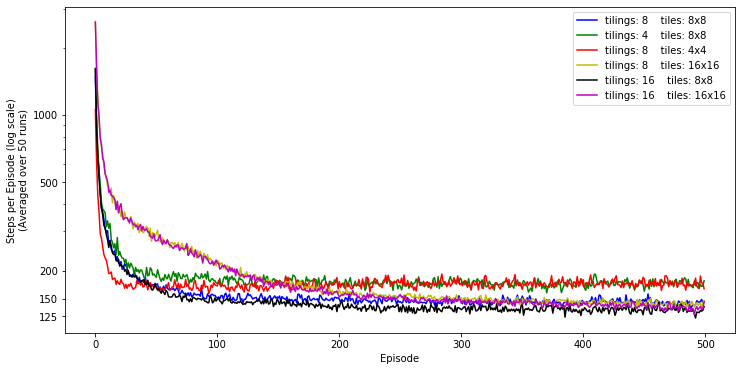

In [6]:
# Experiment to identify tile encoding hyperparameters performance

settings = [(SARSA_agent, {"num_tilings": 8, "num_tiles": [8, 8]}), 
               (SARSA_agent, {"num_tilings": 4, "num_tiles": [8, 8]}),
               (SARSA_agent, {"num_tilings": 8, "num_tiles": [4, 4]}),
               (SARSA_agent, {"num_tilings": 8, "num_tiles": [16, 16]}),
               (SARSA_agent, {"num_tilings": 16, "num_tiles": [8, 8]}),
               (SARSA_agent, {"num_tilings": 16, "num_tiles": [16, 16]})]

labels = ["tilings: 8    tiles: 8x8", "tilings: 4    tiles: 8x8",
          "tilings: 8    tiles: 4x4", "tilings: 8    tiles: 16x16",
          "tilings: 16    tiles: 8x8", "tilings: 16    tiles: 16x16"]

rewards_t1, agent_t1 = run_experient(env, 50, 500, settings)

plot_var_history(rewards_t1, labels, **plot_args)

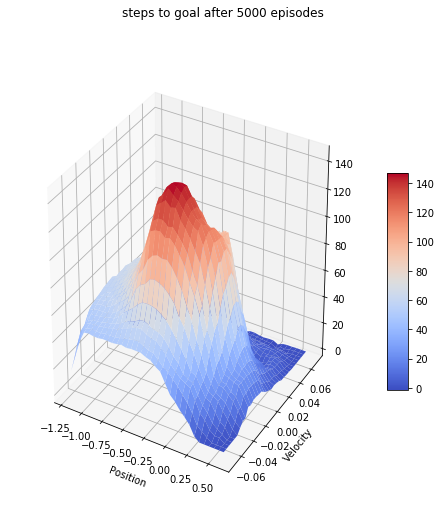

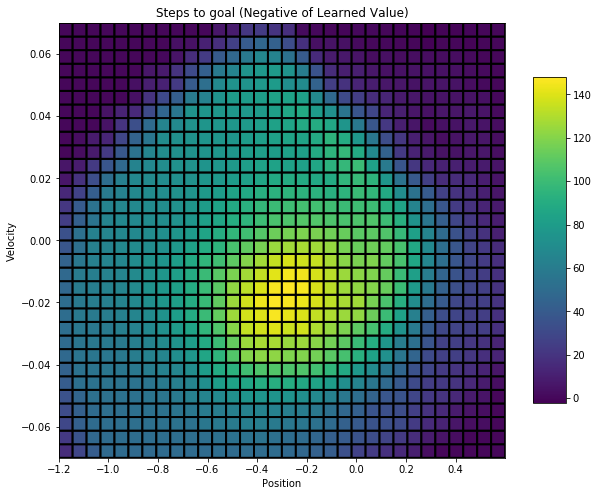

In [7]:
# Experiment to visualize the learning of the value function
settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5})]

rewards_t2, agent_t2 = run_experient(env, 1, 5000, settings,  plot_value_func = True, plot_state_visit=False)

_ = ValuePlot(agent_t2, title_key='(Negative of Learned Value)', Dia_2D=True)

100%|██████████| 1/1 [02:11<00:00, 131.40s/it]


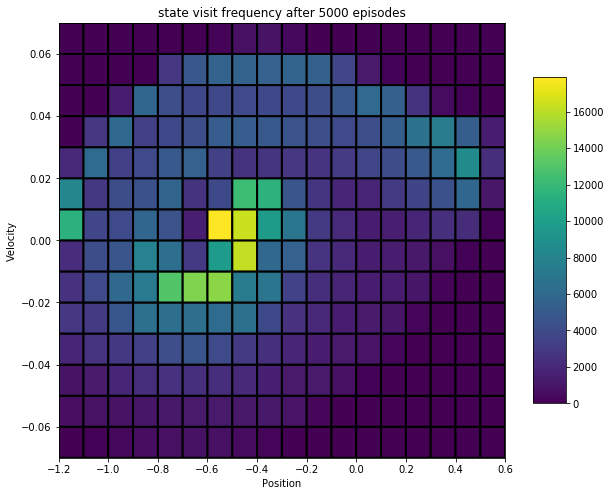

In [8]:
# Experiment to visualize agent exploration
settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5})]

rewards_t3, agent_t3 = run_experient(env, 1, 5000, settings,  plot_value_func = False, plot_state_visit=True)

Parameter Setting 1
100%|██████████| 50/50 [11:28<00:00, 13.77s/it]
Parameter Setting 2
100%|██████████| 50/50 [12:57<00:00, 15.54s/it]
Parameter Setting 3
100%|██████████| 50/50 [11:23<00:00, 13.66s/it]


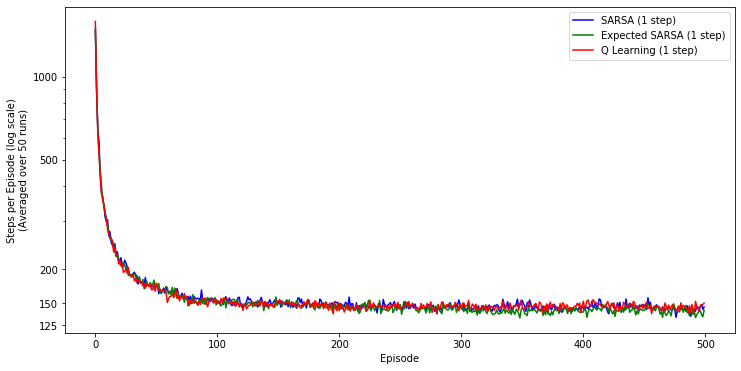

In [10]:
# Experiment to compare different Classical RL agents

settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5}), (Expected_SARSA_agent, {"n_step": 1, "step_size": 0.5}),
            (Q_agent, {"n_step": 1, "step_size": 0.5})]

plot_labels = ["SARSA (1 step)", "Expected SARSA (1 step)", "Q Learning (1 step)"]

rewards_t5, agent_t5 = run_experient(env, 50, 500, settings)

plot_var_history(rewards_t5, plot_labels, **plot_args)

Parameter Setting 4: 100%|██████████| 50/50 [11:09<00:00, 13.40s/it]


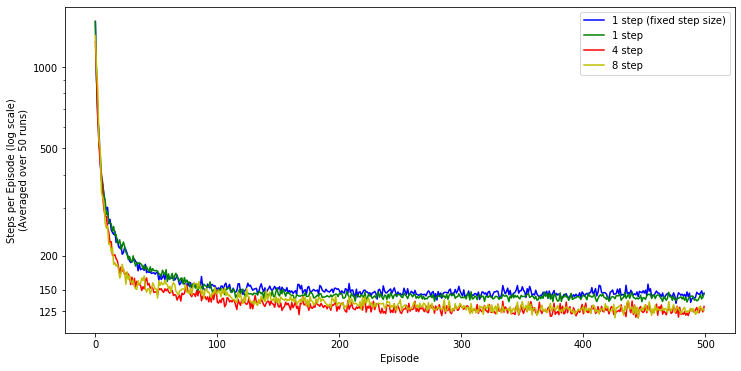

In [5]:
# Experiment to observe effect of bootstrapping in sarsa

settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5}),
            (SARSA_agent, {"n_step": 1, "step_size": 0.5, "decay_factor": 0.99}),
            (SARSA_agent, {"n_step": 4, "step_size": 0.4, "decay_factor": 0.99}),
            (SARSA_agent, {"n_step": 8, "step_size": 0.3, "decay_factor": 0.99})]

plot_labels = ["1 step (fixed step size)", "1 step", "4 step", "8 step"]

rewards_t4, agent_t4 = run_experient(env, 50, 500, settings)

plot_var_history(rewards_t4, plot_labels, **plot_args)